In [1]:
from qiskit import __version__
print(__version__)

1.4.2


In [13]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, state_fidelity, Pauli, DensityMatrix
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile 
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError, pauli_error 
from qiskit.circuit.library import HGate, UnitaryGate, CXGate
import matplotlib.pyplot as plt

# Encoding Circuit

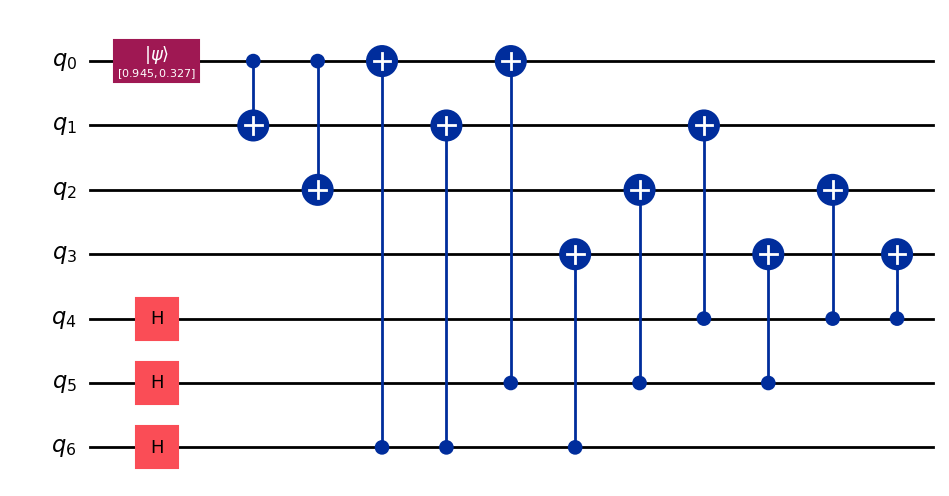

In [3]:
encoding = QuantumCircuit(7)

theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0 = np.cos(theta/2)
amp_1 = np.sin(theta/2)

encoding.initialize([amp_0, amp_1], 0)

for i in range(4, 7):
    encoding.h(i)

encoding.cx(0, 1)
encoding.cx(0, 2)
encoding.cx(6, 0)
encoding.cx(6, 1)
encoding.cx(6, 3)
encoding.cx(5, 0)
encoding.cx(5, 2)
encoding.cx(5, 3)
encoding.cx(4, 1)
encoding.cx(4, 2)
encoding.cx(4, 3)

display(encoding.draw(output='mpl'))

# Measuring Stabilizers Fault Tolerantly

Measuring XXXXIII

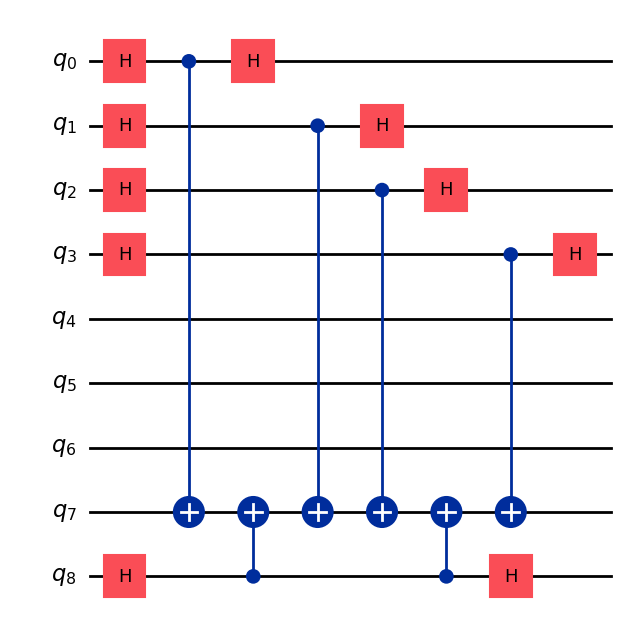

In [4]:
stab1 = QuantumCircuit(9)

# Initialize flag qubit to |+>
stab1.h(8)

stab1.h(0)
stab1.cx(0, 7)
stab1.h(0)

stab1.cx(8, 7)

stab1.h(1)
stab1.cx(1, 7)
stab1.h(1)

stab1.h(2)
stab1.cx(2, 7)
stab1.h(2)

stab1.cx(8, 7)

stab1.h(3)
stab1.cx(3, 7)
stab1.h(3)

# Measure flag qubit in the X-basis
stab1.h(8)

display(stab1.draw(output='mpl'))

Measuring IXXIXXI

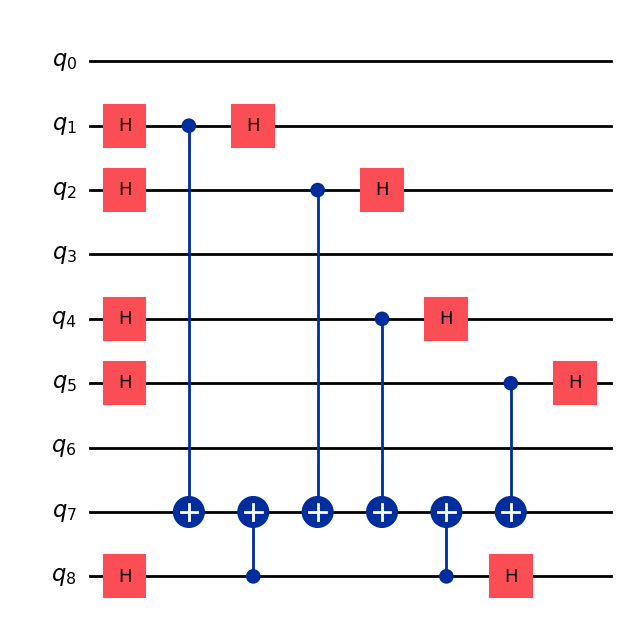

In [5]:
stab2 = QuantumCircuit(9)

# Initialize flag qubit to |+>
stab2.h(8)

stab2.h(1)
stab2.cx(1, 7)
stab2.h(1)

stab2.cx(8, 7)

stab2.h(2)
stab2.cx(2, 7)
stab2.h(2)

stab2.h(4)
stab2.cx(4, 7)
stab2.h(4)

stab2.cx(8, 7)

stab2.h(5)
stab2.cx(5, 7)
stab2.h(5)

# Measure flag qubit in the X-basis
stab2.h(8)

display(stab2.draw(output='mpl'))

Measuring IIXXIXX

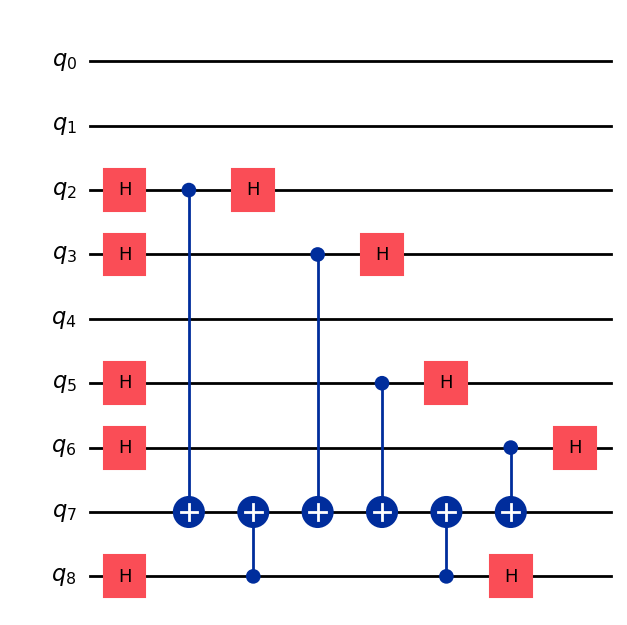

In [6]:
stab3 = QuantumCircuit(9)

# Initialize flag qubit to |+>
stab3.h(8)

stab3.h(2)
stab3.cx(2, 7)
stab3.h(2)

stab3.cx(8, 7)

stab3.h(3)
stab3.cx(3, 7)
stab3.h(3)

stab3.h(5)
stab3.cx(5, 7)
stab3.h(5)

stab3.cx(8, 7)

stab3.h(6)
stab3.cx(6, 7)
stab3.h(6)

# Measure flag qubit in the X-basis
stab3.h(8)

display(stab3.draw(output='mpl'))

Measuring ZZZZIII

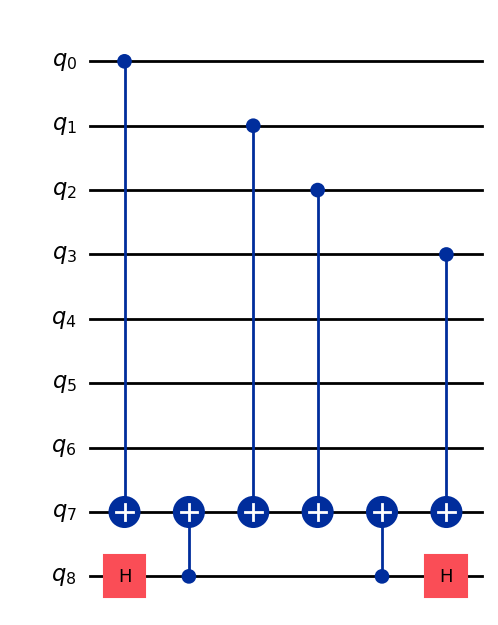

In [7]:
stab4 = QuantumCircuit(9)

# Initialize flag qubit to |+>
stab4.h(8)

stab4.cx(0, 7)

stab4.cx(8, 7)

stab4.cx(1, 7)
stab4.cx(2, 7)

stab4.cx(8, 7)

stab4.cx(3, 7)

# Measure flag qubit in the X-basis
stab4.h(8)

display(stab4.draw(output='mpl'))

Measuring IZZIZZI

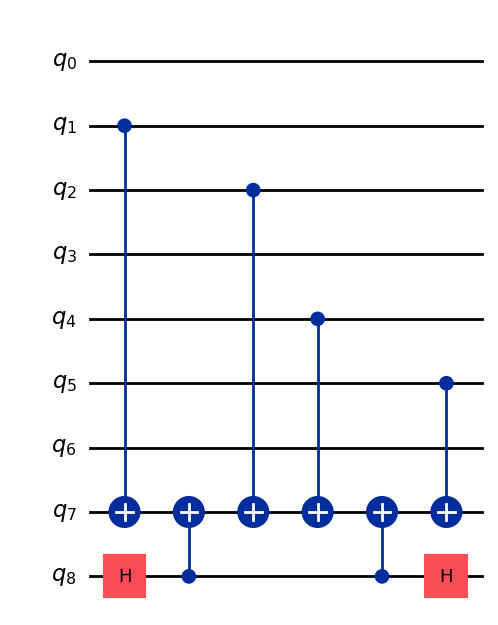

In [8]:
stab5 = QuantumCircuit(9)

# Initialize flag qubit to |+>
stab5.h(8)

stab5.cx(1, 7)

stab5.cx(8, 7)

stab5.cx(2, 7)
stab5.cx(4, 7)

stab5.cx(8, 7)

stab5.cx(5, 7)

# Measure flag qubit in the X-basis
stab5.h(8)

display(stab5.draw(output='mpl'))

Measuring IIZZIZZ

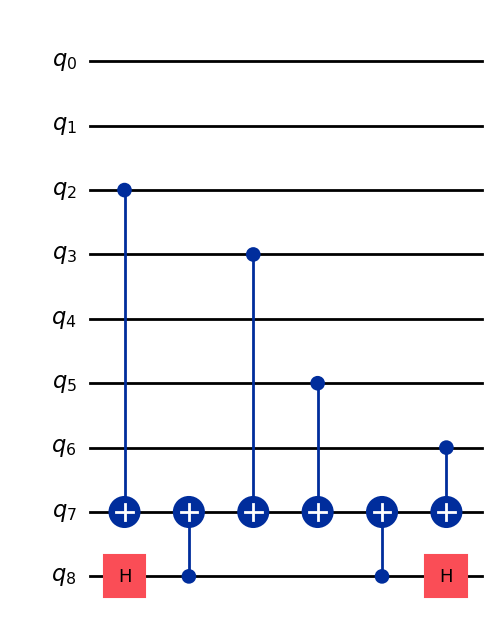

In [9]:
stab6 = QuantumCircuit(9)

# Initialize flag qubit to |+>
stab6.h(8)

stab6.cx(2, 7)

stab6.cx(8, 7)

stab6.cx(3, 7)
stab6.cx(5, 7)

stab6.cx(8, 7)

stab6.cx(6, 7)

# Measure flag qubit in the X-basis
stab6.h(8)

display(stab6.draw(output='mpl'))

# Measuring Stabilizers Not Fault Tolerantly

In [14]:
# Creating custom gates, so the noise model doens't affect these circuits

H_matrix = HGate().to_matrix()
s_hadamard = UnitaryGate(H_matrix, label='s_hadamard')

CX_matrix = CXGate().to_matrix()
s_CX = UnitaryGate(CX_matrix, label='s_CX')

Measuring XXXXIII

In [16]:
stab1_nft = QuantumCircuit(9)

# Initialize flag qubit to |+>
stab1_nft.append(s_hadamard, [8])

stab1_nft.append(s_hadamard,[0])
stab1_nft.append(s_CX, [0, 7])
stab1_nft.append(s_hadamard, [0])

stab1_nft.append(s_CX, [8, 7])

stab1_nft.append(s_hadamard, [1])
stab1_nft.append(s_CX, [1, 7])
stab1_nft.append(s_hadamard, [1])

stab1_nft.append(s_hadamard, [2])
stab1_nft.append(s_CX, [2, 7])
stab1_nft.append(s_hadamard, [2])

stab1_nft.append(s_CX, [8, 7])

stab1_nft.append(s_hadamard, [3])
stab1_nft.append(s_CX, [3, 7])
stab1_nft.append(s_hadamard, [3])

# Measure flag qubit in the X-basis
stab1_nft.append(s_hadamard, [8])

Measuring IXXIXXI

In [19]:
stab2_nft = QuantumCircuit(9)

# Initialize flag qubit to |+>
stab2_nft.append(s_hadamard, [8])

stab2_nft.append(s_hadamard, [1])
stab2_nft.append(s_CX, [1, 7])
stab2_nft.append(s_hadamard, [1])

stab2_nft.append(s_CX, [8, 7])

stab2_nft.append(s_hadamard, [2])
stab2_nft.append(s_CX, [2, 7])
stab2_nft.append(s_hadamard, [2])

stab2_nft.append(s_hadamard, [4])
stab2_nft.append(s_CX, [4, 7])
stab2_nft.append(s_hadamard, [4])

stab2_nft.append(s_CX, [8, 7])

stab2_nft.append(s_hadamard, [5])
stab2_nft.append(s_CX, [5, 7])
stab2_nft.append(s_hadamard, [5])

# Measure flag qubit in the X-basis
stab2_nft.append(s_hadamard, [8])

Measuring IIXXIXX

In [20]:
stab3_nft = QuantumCircuit(9)

# Initialize flag qubit to |+>
stab3_nft.append(s_hadamard, [8])

stab3_nft.append(s_hadamard, [2])
stab3_nft.append(s_CX, [2, 7])
stab3_nft.append(s_hadamard, [2])

stab3_nft.append(s_CX, [8, 7])

stab3_nft.append(s_hadamard, [3])
stab3_nft.append(s_CX, [3, 7])
stab3_nft.append(s_hadamard, [3])

stab3_nft.append(s_hadamard, [5])
stab3_nft.append(s_CX, [5, 7])
stab3_nft.append(s_hadamard, [5])

stab3_nft.append(s_CX, [8, 7])

stab3_nft.append(s_hadamard, [6])
stab3_nft.append(s_CX, [6, 7])
stab3_nft.append(s_hadamard, [6])

# Measure flag qubit in the X-basis
stab3_nft.append(s_hadamard, [8])

Measuring ZZZZIII

In [21]:
stab4_nft = QuantumCircuit(9)

# Initialize flag qubit to |+>
stab4_nft.append(s_hadamard, [8])

stab4_nft.append(s_CX, [0, 7])

stab4_nft.append(s_CX, [8, 7])

stab4_nft.append(s_CX, [1, 7])
stab4_nft.append(s_CX, [2, 7])

stab4_nft.append(s_CX, [8, 7])

stab4_nft.append(s_CX, [3, 7])

# Measure flag qubit in the X-basis
stab4_nft.append(s_hadamard, [8])

Measuring IZZIZZI

In [22]:
stab5_nft = QuantumCircuit(9)

# Initialize flag qubit to |+>
stab5_nft.append(s_hadamard, [8])

stab5_nft.append(s_CX, [1, 7])

stab5_nft.append(s_CX, [8, 7])

stab5_nft.append(s_CX, [2, 7])
stab5_nft.append(s_CX, [4, 7])

stab5_nft.append(s_CX, [8, 7])

stab5_nft.append(s_CX, [5, 7])

# Measure flag qubit in the X-basis
stab5_nft.append(s_hadamard, [8])

Measuring IIZZIZZ

In [23]:
stab6_nft = QuantumCircuit(9)

# Initialize flag qubit to |+>
stab6_nft.append(s_hadamard, [8])

stab6_nft.append(s_CX, [2, 7])

stab6_nft.append(s_CX, [8, 7])

stab6_nft.append(s_CX, [3, 7])
stab6_nft.append(s_CX, [5, 7])

stab6_nft.append(s_CX, [8, 7])

stab6_nft.append(s_CX, [6, 7])

# Measure flag qubit in the X-basis
stab6_nft.append(s_hadamard, [8])

# Logical Error Rate for Encoding Circuit

In [85]:
logical_error_circ = QuantumCircuit(9, 2)

logical_error_circ.initialize([amp_0, amp_1], 0)

for i in range(7):
    logical_error_circ.id(i)

for i in range(4, 7):
    logical_error_circ.h(i)

logical_error_circ.cx(0, 1)
logical_error_circ.cx(0, 2)
logical_error_circ.cx(6, 0)
logical_error_circ.cx(6, 1)
logical_error_circ.cx(6, 3)
logical_error_circ.cx(5, 0)
logical_error_circ.cx(5, 2)
logical_error_circ.cx(5, 3)
logical_error_circ.cx(4, 1)
logical_error_circ.cx(4, 2)
logical_error_circ.cx(4, 3)

In [66]:
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,2), ['cx'])

# 5% chance of flipping 0 <-> 1
readout_err = ReadoutError([[0.995, 0.005],  # P(measured 0 | actual 0), P(1 | 0)
                            [0.005, 0.995]]) # P(0 | 1), P(1 | 1)

# Apply to all qubits being measured
noise_model.add_readout_error(readout_err, [7])
noise_model.add_readout_error(readout_err, [8])


meas_circuit_noise = logical_error_circ.copy()
meas_circuit_noise.barrier()

# Measure FT XXXXIII
meas_circuit_noise.compose(stab1, inplace=True) 
meas_circuit_noise.measure([7, 8], [0, 1])

backend = AerSimulator(noise_model=noise_model)
transpiled = transpile(meas_circuit_noise, backend)
job = backend.run(transpiled, shots=1, memory=True)
result = job.result()
#print(result)

memory = result.get_memory()[0]
flag =  1 if memory[1] == '0' else -1

01


In [ ]:
base = logical_error_circ.copy()

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,1), ['id','h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,2), ['cx'])
ro_err = ReadoutError([[0.995,0.005],[0.005,0.995]])
noise_model.add_readout_error(ro_err, [7])
noise_model.add_readout_error(ro_err, [8])

# Measuring XXXXIII
qc = base.copy()
qc.barrier()
qc.compose(stab1, inplace=True)
qc.measure([7,8], [0,1])

qc.reset([7, 8])
qc.compose(stab1_nft, inplace=True)
qc.measure([7], [0])

backend = AerSimulator(noise_model=noise_model)
tlist = transpile(qc, backend)
job   = backend.run(tlist, shots=1, memory=True)
res   = job.result()
mem_ft = res.get_memory()[0]
mem_nft = res.get_memory()[1]
print(mem_ft)
print(mem_nft)

"""
flag = 1
if (mem == ['10']):
    flag = 1
elif (mem == ['01'] or mem == ['11']):
    flag = -1


qc.reset([7])
qc.compose(stab2_nft, inplace=True)
qc.measure([7], [0])

qc.reset([7])
qc.compose(stab3_nft, inplace=True)
qc.measure([7], [0])

qc.reset([7])
qc.compose(stab4_nft, inplace=True)
qc.measure([7], [0])

qc.reset([7])
qc.compose(stab5_nft, inplace=True)
qc.measure([7], [0])

qc.reset([7])
qc.compose(stab6_nft, inplace=True)
qc.measure([7], [0])"""
